# Dynamics 365 Business Central Troubleshooting Guide (TSG) - Usage of deprecated web service protocols

This notebook contains Kusto queries that can help determining if one ore more environments are still using web services build on the depreated Odata v3 protocol. Queries go back 30 days

NB! The signal used in this notebook is only available in versions 16.1 (or newer) of Business Central, so check the version of your environment if you don't see any data.

Web service request signal is documented here: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace 

## 1\. Get setup: Load up Python libraries and connect to Application Insights
First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it? <span style="color: rgb(0, 128, 0); font-family: Consolas, &quot;Courier New&quot;, monospace; font-size: 12px; white-space: pre;">Install&nbsp;instructions:&nbsp;https://github.com/microsoft/BCTech/tree/master/samples/AppInsights/TroubleShootingGuides</span>) and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


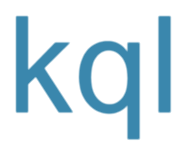

In [1]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [2]:
# Connect to the Application Insights API
%kql appinsights://appid='<add app id from the Application Insights portal>';appkey='<add API key from the Application Insights portal>'

## 2\. Define filters

This workbook is designed for troubleshooting environments in an AAD subscription. Please provide values for aadTenantId below (or use a config file).

In [3]:
# Add values for AAD tenant id, environment name, and date range.
# It is possible to leave the value for AAD tenant id or environment name blank (if you want to analyze across all values of the parameter)

# You can either use configuration file (INI file format) or set filters directly. 

# If you specify a config file, then variables set here takes precedence over manually set filter variables
# config file name and directory (full path)
configFile = "c:\\tmp\\notebook.ini"


# Add AAD tenant id and environment name here (or leave blank)
aadTenantId = ""
environmentName = ""

# date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = "2021-11-20"
endDate = "2022-01-01"



# Do not edit this code section
import configparser
config = configparser.ConfigParser()

config.read(configFile)

if bool(config.defaults()):
    if config.has_option('DEFAULT', 'aadTenantId'):
        aadTenantId = config['DEFAULT']['aadTenantId']
    if config.has_option('DEFAULT', 'environmentName'):
        environmentName = config['DEFAULT']['environmentName']
    if config.has_option('DEFAULT', 'extensionId'):
        extensionId = config['DEFAULT']['extensionId']
    if config.has_option('DEFAULT', 'startDate'):    
        startDate = config['DEFAULT']['startDate']
    if config.has_option('DEFAULT', 'endDate'):
        endDate = config['DEFAULT']['endDate']

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("aadTenantId         " + aadTenantId)
print("environmentName     " + environmentName)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
aadTenantId         
environmentName     
startDate           2021-11-20
endDate             2022-01-01


# Analyze usage of web services

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries

Telemetry docs: https://docs.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-webservices-trace

KQL samples
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/RawData/WebServiceCalls.kql
* https://github.com/microsoft/BCTech/blob/master/samples/AppInsights/KQL/DeprecatedWebServiceProtocols.kql

## Request stats (last 30 days)
The first report shows statistics for all categories.

The second report shows statistics only for deprecated categories.


In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and timestamp > ago(30d)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
| extend category = tostring( customDimensions.category )
| summarize request_count=count() by category, bin(timestamp, 1d)
| render timechart title= 'Number of web service requests by category (ODatav4, ODatav3, SOAP, API)'

In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and timestamp > ago(30d)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.category == 'ODataV3'
| extend category = tostring( customDimensions.category )
| summarize request_count=count() by category, bin(timestamp, 1d)
| render timechart title= 'Number of web service requests by category (deprecated categories)'

## Web service endpoints using deprecated protocols

The following endpoints are exposed ad web service endpoints using a deprecated protocol (query shows the first 100)

In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and timestamp > ago(30d)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
    and customDimensions.category == 'ODataV3'
| project aadId = tostring( customDimensions.aadTenantId )
        , environmentName = tostring( customDimensions.environmentName )
        , category = tostring( customDimensions.category )
        , endpoint = tostring( customDimensions.endpoint )
| distinct aadId
        , environmentName 
        , category 
        , endpoint
| limit 100

## Web service endpoints using deprecated basic authentication

The following endpoints are exposed ad web service endpoints using basic authentication, which is deprecated in Business Central online (query shows the first 100)

In [ ]:
%%kql
let _aadTenantId = aadTenantId;
let _environmentName = environmentName;
traces
| where 1==1 
    and timestamp > ago(30d)
    and (_aadTenantId == '' or customDimensions.aadTenantId == _aadTenantId)
    and (_environmentName == '' or customDimensions.environmentName == _environmentName )
    and customDimensions.eventId == 'RT0008'
// httpHeaders only available from 16.3        
| extend httpHeaders = customDimensions.httpHeaders       
| extend httpHeadersTmp =  tostring( httpHeaders)
| extend httpHeadersJSON = parse_json(httpHeadersTmp)
| extend msUserAgent = tostring( httpHeadersJSON.['ms-dyn-useragent'] )
// Authorization header (truncated) available from 17.3
| extend httpAuthorization = tostring( httpHeadersJSON.['Authorization'] ) 
| where httpAuthorization == '["Basic <redacted>"]'
| project aadId = tostring( customDimensions.aadTenantId )
        , environmentName = tostring( customDimensions.environmentName )
        , category = tostring( customDimensions.category )
        , endpoint = tostring( customDimensions.endpoint )
        , httpAuthorization
| distinct aadId
        , environmentName 
        , category 
        , endpoint
| limit 100